**Fashion MNIST Classification Using CNN in TensorFlow and Keras**

In [8]:
import tensorflow as tf
import seaborn as sns
import keras
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input, BatchNormalization
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.utils import to_categorical
from sklearn.metrics import classification_report, confusion_matrix
import numpy as np
import json
from tensorflow.keras.optimizers import Adam
from keras.utils import img_to_array
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.regularizers import l2  # Import l2 regularization
from sklearn.metrics import confusion_matrix

In [9]:
def plot_confusion_matrix(model, x_val, y_val):
    y_pred = model.predict(x_val)
    y_pred_classes = np.argmax(y_pred, axis=1)
    y_true = np.argmax(y_val, axis=1)

    cm = confusion_matrix(y_true, y_pred_classes)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=range(10), yticklabels=range(10))
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.title('Confusion Matrix')
    plt.show()

def plot_training_history(history):
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Accuracy over Epochs')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

def train_model(model, x_train, y_train, x_val, y_val, epochs=10, batch_size=32):
    history = model.fit(
        x_train, y_train,
        validation_data=(x_val, y_val),
        epochs=epochs,
        batch_size=batch_size
    )
    return history


**Prepration of data for the first and second models**

In [10]:
def load_fashion_mnist_1_2():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)
    return x_train, y_train, x_test, y_test

def build_model_1():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1), kernel_regularizer=l2(0.01)),  # L2 Regularization
        MaxPooling2D((2, 2)),
        Dropout(0.25),  # Increased dropout rate
        Flatten(),
        Dropout(0.25),
        Dense(128, activation='relu', kernel_regularizer=l2(0.01)),  # L2 Regularization in dense layer
        Dropout(0.25),
        Dense(10, activation='softmax')
    ])
    model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

# Define Model2
def build_model_2():


    model = Sequential([
        Input(shape=(28, 28, 1)),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Conv2D(128, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Dropout(0.3),
        Flatten(),
        Dense(256, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')
    ])

    model.compile(optimizer=Adam(), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

**Prepration of data for the third model**

In [11]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.applications import ResNet50

#  Load and Preprocess Fashion MNIST Data
def load_fashion_mnist_3():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    # Convert grayscale to RGB (ResNet-50 expects 3 channels)
    x_train = np.repeat(x_train[..., np.newaxis], 3, -1)
    x_test = np.repeat(x_test[..., np.newaxis], 3, -1)

    #  Resize images to 32x32 (ResNet requires larger input)
    x_train = tf.image.resize(x_train, (32, 32)).numpy()
    x_test = tf.image.resize(x_test, (32, 32)).numpy()

    #  Normalize pixel values to [0, 1]
    x_train = x_train.astype("float32") / 255.0
    x_test = x_test.astype("float32") / 255.0

    #  Convert labels to one-hot encoding (for categorical crossentropy)
    y_train = to_categorical(y_train, 10)
    y_test = to_categorical(y_test, 10)

    return x_train, y_train, x_test, y_test

#  Define ResNet-50 Model
def build_model_3():
    # Load pre-trained ResNet-50 model without the top layer
    pretrained_model = ResNet50(weights="imagenet", include_top=False, input_shape=(32, 32, 3))

    # Unfreeze last 30 layers for fine-tuning
    for layer in pretrained_model.layers[-30:]:
        layer.trainable = True

    #  Functional API for model definition
    x = Flatten()(pretrained_model.output)
    x = Dense(100, activation='relu')(x)
    x = Dropout(0.5)(x)
    output = Dense(10, activation='softmax')(x)

    #  Corrected: Use `Model()`, not `Model3()`
    model = Model(inputs=pretrained_model.input, outputs=output)

    #  Compile the model
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    return model

#  Load dataset
x_train, y_train, x_test, y_test = load_fashion_mnist_3()

#  Build and Summarize Model
model3 = build_model_3()
model3.summary()


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 32, 32, 3)      │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_pad (ZeroPadding2D) │ (None, 38, 38, 3)      │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 16, 16, 64)     │          9,472 │ conv1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 16, 16, 64)     │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 16, 16, 64)     │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pad (ZeroPadding2D) │ (None, 18, 18, 64)     │              0 │ conv1_relu[0][0]       │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1_pool (MaxPooling2D) │ (None, 8, 8, 64)       │              0 │ pool1_pad[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 8, 8, 64)       │          4,160 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 8, 8, 64)       │         36,928 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_bn         │ (None, 8, 8, 64)       │            256 │ conv2_block1_2_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_relu       │ (None, 8, 8, 64)       │              0 │ conv2_block1_2_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_conv       │ (None, 8, 8, 256)      │         16,640 │ pool1_pool[0][0]       │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_3_conv       │ (None, 8, 8, 256)      │         16,640 │ conv2_block1_2_relu[0… │
│ (Conv2D)             

 Total params: 23,793,622 (90.77 MB)

 Trainable params: 23,740,502 (90.56 MB)

 Non-trainable params: 53,120 (207.50 KB)

**Trainining Model 1**

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 13s 5ms/step - accuracy: 0.7668 - loss: 0.6894 - val_accuracy: 0.8776 - val_loss: 0.3596
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8731 - loss: 0.3868 - val_accuracy: 0.8893 - val_loss: 0.3270
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 3ms/step - accuracy: 0.8833 - loss: 0.3465 - val_accuracy: 0.8901 - val_loss: 0.3150
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8881 - loss: 0.3280 - val_accuracy: 0.9004 - val_loss: 0.2911
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8950 - loss: 0.3091 - val_accuracy: 0.9009 - val_loss: 0.2870
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8989 - loss: 0.2929 - val_accuracy: 0.9014 - val_loss: 0.2900
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9006 - loss: 0.2859 - val_accuracy: 0.9054 - val_loss: 0.2752
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.9057 - loss: 0.2733

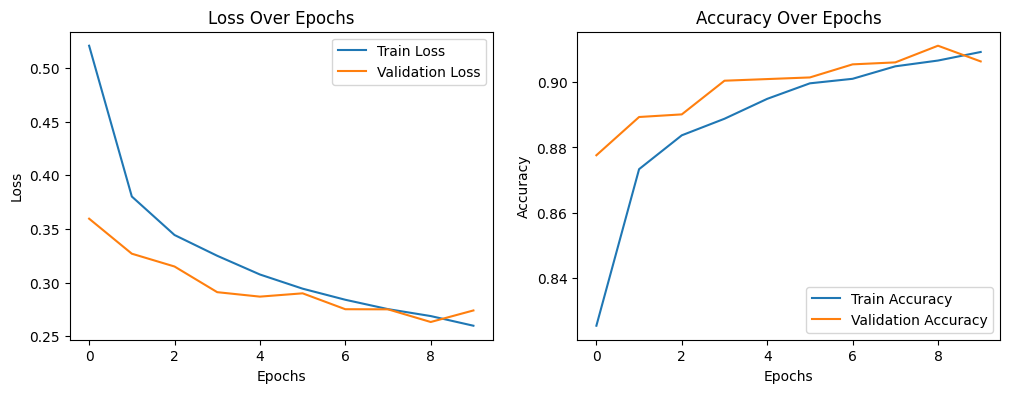

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


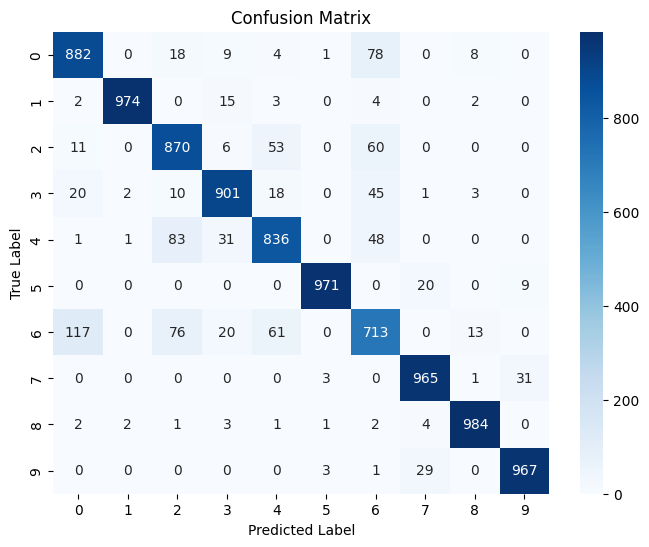

In [12]:
# Load dataset function (Ensure it is defined)
def load_fashion_mnist_1_2():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
    return x_train, y_train, x_test, y_test

# Function to preprocess dataset
def preprocess_data(x_train, y_train, x_test, y_test):
    # Normalize pixel values to [0,1]
    x_train = x_train.reshape(-1, 28, 28, 1).astype('float32') / 255.0
    x_test = x_test.reshape(-1, 28, 28, 1).astype('float32') / 255.0

    # Convert labels to categorical (optional, based on the loss function used)
    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)

    return x_train, y_train, x_test, y_test

# Function to build the CNN model
def build_model_1():
    model = Sequential([
        Input(shape=(28, 28, 1)),  # Explicitly define input layer
        Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(0.01)),
        MaxPooling2D((2, 2)),
        Dropout(0.25),

        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(10, activation='softmax')  # Output layer with 10 classes
    ])

    # Use sparse_categorical_crossentropy if labels are integers
    model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
    return model

# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.show()

# Function to plot confusion matrix
def plot_confusion_matrix(model, x_test, y_test):
    y_pred = np.argmax(model.predict(x_test), axis=1)
    cm = confusion_matrix(y_test, y_pred)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix")
    plt.show()

# Load dataset
x_train, y_train, x_test, y_test = load_fashion_mnist_1_2()

# Preprocess dataset
x_train, y_train, x_test, y_test = preprocess_data(x_train, y_train, x_test, y_test)

# Build and train model
model1 = build_model_1()

history1 = model1.fit(
    x_train, y_train,
    validation_data=(x_test, y_test),
    epochs=10,
    batch_size=32
)

# Evaluate model
train_loss, train_accuracy = model1.evaluate(x_train, y_train, verbose=0)
val_loss, val_accuracy = model1.evaluate(x_test, y_test, verbose=0)

# Plot training history
plot_training_history(history1)

# Plot confusion matrix
plot_confusion_matrix(model1, x_test, y_test)


**model 2**

Epoch 1/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 14s 5ms/step - accuracy: 0.7556 - loss: 0.6723 - val_accuracy: 0.8740 - val_loss: 0.3436
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 15s 4ms/step - accuracy: 0.8704 - loss: 0.3551 - val_accuracy: 0.8919 - val_loss: 0.2983
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.8860 - loss: 0.3057 - val_accuracy: 0.8956 - val_loss: 0.2850
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8973 - loss: 0.2774 - val_accuracy: 0.8934 - val_loss: 0.2822
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9069 - loss: 0.2481 - val_accuracy: 0.9059 - val_loss: 0.2593
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9101 - loss: 0.2375 - val_accuracy: 0.9042 - val_loss: 0.2650
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 8s 4ms/step - accuracy: 0.9163 - loss: 0.2192 - val_accuracy: 0.9147 - val_loss: 0.2425
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.9206 - loss: 0.21

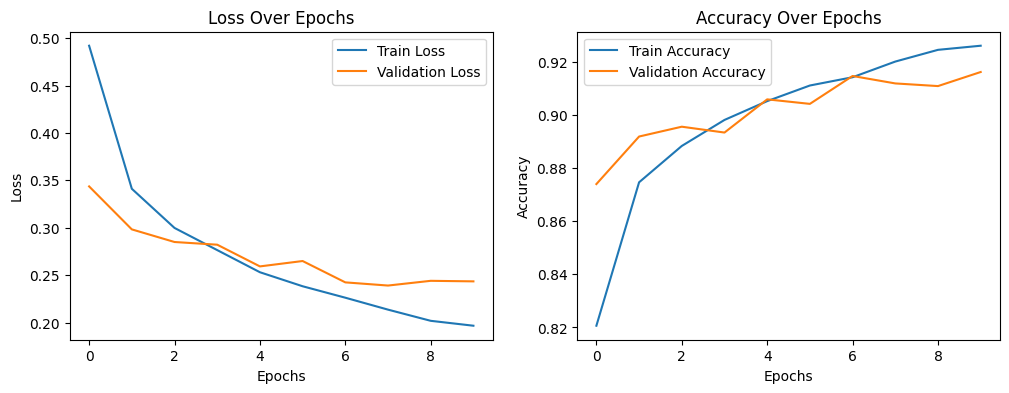

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


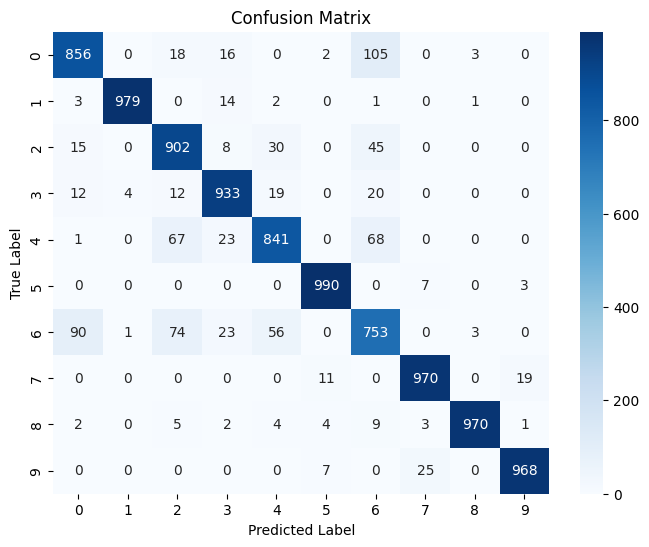

In [13]:
# Build and train Model2
model2 = build_model_2()
history2 = model2.fit(x_train, y_train, validation_data=(x_test, y_test), epochs=10, batch_size=32)

# Evaluate Model2
train_loss, train_accuracy = model2.evaluate(x_train, y_train, verbose=0)
val_loss, val_accuracy = model2.evaluate(x_test, y_test, verbose=0)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")

# Plot results
plot_training_history(history2)
plot_confusion_matrix(model2, x_test, y_test)

**model3**

In [14]:
x_train, y_train, x_test, y_test = load_fashion_mnist_3()
print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)


(60000, 32, 32, 3) (60000, 10) (10000, 32, 32, 3) (10000, 10)


In [15]:
from tensorflow.keras.models import Model


def build_model_3():
    base_model = ResNet50(weights="imagenet", include_top=False, input_tensor=Input(shape=(32, 32, 3)))

    # Unfreeze some layers
    for layer in base_model.layers[-20:]:  # Unfreezing the last 20 layers
        layer.trainable = True

    # Add custom layers for Fashion MNIST classification
    x = Flatten()(base_model.output)
    x = Dense(256, activation='relu')(x)
    x = Dense(10, activation='softmax')(x)

    model = Model(inputs=base_model.input, outputs=x)

    model.compile(optimizer=Adam(learning_rate=0.0001), loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model


In [16]:
import cv2

def load_fashion_mnist_3():
    (x_train, y_train), (x_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()

    # Resize to (32, 32) and convert to 3-channel (RGB)
    x_train = np.array([cv2.resize(img, (32, 32)) for img in x_train])
    x_test = np.array([cv2.resize(img, (32, 32)) for img in x_test])

    # Convert grayscale to 3-channel RGB
    x_train = np.stack([x_train] * 3, axis=-1).astype('float32') / 255.0
    x_test = np.stack([x_test] * 3, axis=-1).astype('float32') / 255.0

    y_train = y_train.astype(np.int32)
    y_test = y_test.astype(np.int32)

    return x_train, y_train, x_test, y_test


In [17]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Load dataset
x_train, y_train, x_test, y_test = load_fashion_mnist_3()

# Data augmentation for better performance
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    horizontal_flip=True
)
datagen.fit(x_train)

# Build and train the model
model3 = build_model_3()

history3 = model3.fit(
    datagen.flow(x_train, y_train, batch_size=32),
    validation_data=(x_test, y_test),
    epochs=10,
    verbose=1
)

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_376']
Received: inputs=Tensor(shape=(None, 32, 32, 3))
  warnings.warn(msg)


1875/1875 ━━━━━━━━━━━━━━━━━━━━ 138s 41ms/step - accuracy: 0.7047 - loss: 0.8834 - val_accuracy: 0.8663 - val_loss: 0.3645
Epoch 2/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 38ms/step - accuracy: 0.8592 - loss: 0.3910 - val_accuracy: 0.8754 - val_loss: 0.3351
Epoch 3/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 38ms/step - accuracy: 0.8798 - loss: 0.3406 - val_accuracy: 0.9037 - val_loss: 0.2699
Epoch 4/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 71s 38ms/step - accuracy: 0.8861 - loss: 0.3112 - val_accuracy: 0.9034 - val_loss: 0.2740
Epoch 5/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 38ms/step - accuracy: 0.8918 - loss: 0.3024 - val_accuracy: 0.9111 - val_loss: 0.2486
Epoch 6/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 71s 38ms/step - accuracy: 0.9009 - loss: 0.2791 - val_accuracy: 0.9058 - val_loss: 0.2659
Epoch 7/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 72s 38ms/step - accuracy: 0.9053 - loss: 0.2611 - val_accuracy: 0.9195 - val_loss: 0.2365
Epoch 8/10
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 70s 37ms/step - accuracy: 0.9069 - loss: 0.2

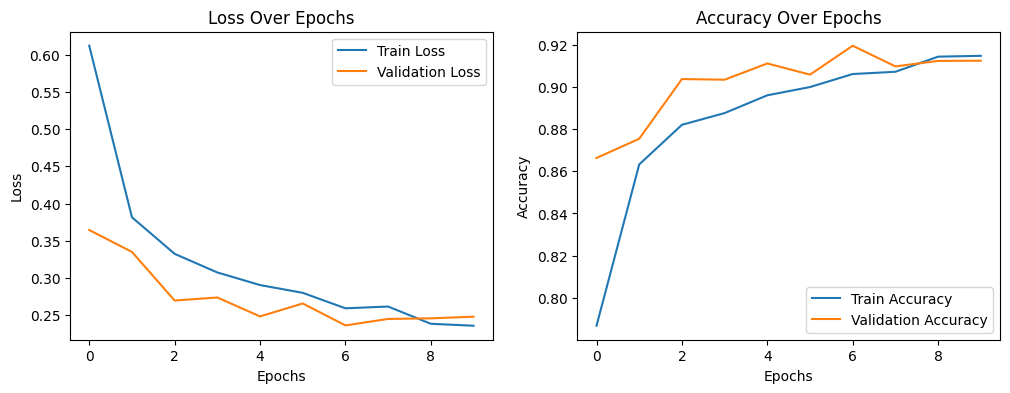

In [18]:

def plot_training_history(history):
    plt.figure(figsize=(12, 4))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.title('Loss Over Epochs')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.title('Accuracy Over Epochs')

    plt.show()

# Call the function to plot training graphs
plot_training_history(history3)


/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['keras_tensor_376']
Received: inputs=Tensor(shape=(32, 32, 32, 3))
  warnings.warn(msg)


313/313 ━━━━━━━━━━━━━━━━━━━━ 11s 19ms/step


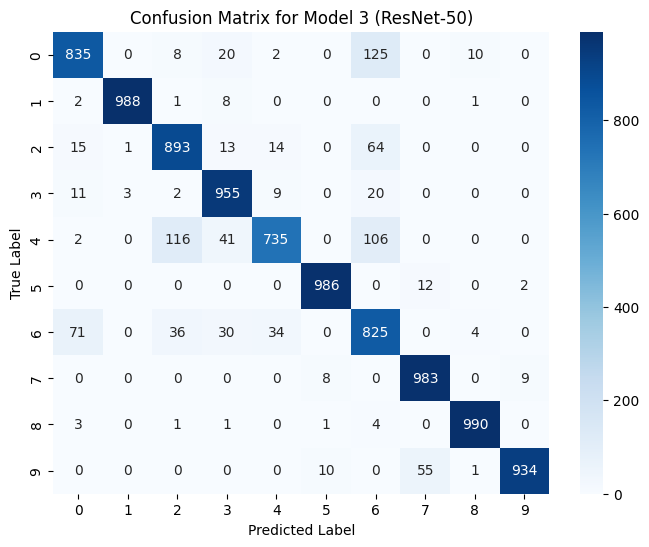

In [19]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, x_test, y_test, model_name="Model 3 (ResNet-50)"):
    # Get predictions
    y_pred = np.argmax(model.predict(x_test), axis=1)

    # Convert one-hot encoded labels back to integer format (if needed)
    if len(y_test.shape) > 1:
        y_test = np.argmax(y_test, axis=1)

    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)

    # Plot confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=range(10), yticklabels=range(10))
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(f"Confusion Matrix for {model_name}")
    plt.show()

#  Call the function after training Model 3
plot_confusion_matrix(model3, x_test, y_test)
